## Import Library

In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# from model.unet import Model      # UNet
# from model.efficientnet_unet import Model  # EfficientNet (Encoder) + UNet (Decoder)
from model.efficientnet_cbam_unet import Model  # EfficientNet (Encoder) + CBAM + UNet (Decoder)

from dataset.dataset import Dataset
from utils.visualize import visualize_predictions, visualize_predictions_jupyter
from utils.mask import predict_masks, create_masks_dict, save_images_if_required, reorder_dict_data

## Set Global Variable

In [2]:
# Freeze seed
torch.manual_seed(0)

# Define paths
CHECKPOINT_PATH = ''
TRAIN_INDEX_PATH = 'data/train_toy_idx.txt'
TEST_INDEX_PATH = 'data/test_toy_idx.txt'

# Define modes
MODE ='test'                               # train / test / csv
RECORD = False                              # Record predictions in wandb
SAVE_MODEL_NAME = 'EfficientNet_CBAM_UNet'  # Name of model to save
SAVE_IMAGES = False                         # Save images 
EXPORT_TO_CSV_AFTER_TRAIN = True            # Export predictions to csv after training
JUPYTER_NOTEBOOK = True                     # Run in Jupyter Notebook

# Define hyperparameters
EPOCHS = 5
BATCH_SIZE = 3                              # While MODE = 'test', remember to set BATCH_SIZE = 1
LEARNING_RATE = 1e-4

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Setup WanDB for tracking

In [3]:
import wandb
from datetime import datetime

def get_current_timestamp():
    now = datetime.now()
    timestamp = now.strftime("%Y_%m_%d_%H%M%S")
    return timestamp

timestamp = get_current_timestamp()
log_dir = f'checkpoint/{timestamp}_{SAVE_MODEL_NAME}'

if RECORD and MODE == 'train':
    wandb.init(
        # set the wandb project where this run will be logged
        project="Face_Segmentation",
        name=f'{timestamp}_{SAVE_MODEL_NAME}',
        
        # track hyperparameters and run metadata
        config={
        "learning_rate": 1e-4,
        "architecture": "CNN",
        "dataset": "CelebAMaskHQ",
        "epochs": 30,
        "Dropout": 0.2,
        "CBAM": "reduction_ratio=16, kernel_size=5",
        "batch_size": 8,
        }
    )

## Set Current Working Directory to current location

In [4]:
# Change current working directory to file location
if JUPYTER_NOTEBOOK:
    current_folder = globals()['_dh'][0]
    os.chdir(current_folder)
else:
    os.chdir(os.path.dirname(__file__))

## Setup model

In [5]:
# Create U-Net model
model = Model(3, 19)
model = model.to(device)

# Print total number of parameters
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())}')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Load dataset
train_dataset = Dataset(id_file=TRAIN_INDEX_PATH, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = Dataset(id_file=TEST_INDEX_PATH, transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Loaded pretrained weights for efficientnet-b4
Total number of parameters: 58725503


## Setup TA Prediction function

In [6]:
labels_celeb = ['background', 'skin', 'l_brow', 
                'r_brow', 'l_eye', 'r_eye', 'eye_g', 
                'l_ear', 'r_ear', 'ear_r', 'nose', 
                'mouth', 'u_lip', 'l_lip', 'neck', 
                'neck_l', 'cloth', 'hair', 'hat']

labels_celeb_origin = ['background', 'skin', 'nose',
                       'eye_g', 'l_eye', 'r_eye', 'l_brow',
                       'r_brow', 'l_ear', 'r_ear', 'mouth',
                       'u_lip', 'l_lip', 'hair', 'hat',
                       'ear_r', 'neck_l', 'neck', 'cloth']


def read_mask(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if type(img) is type(None):
        return np.zeros((256, 256, 1), dtype=np.uint8)
    return img


def mask2binary(path):
    mask = read_mask(path)
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
    mask = np.where(mask > 0, 1, 0)
    return mask


def rle_encode(img):
    pixels = img.flatten()
    if np.sum(pixels) == 0:
        return '0'
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    # to string sep='_'
    runs = '_'.join(str(x) for x in runs)
    return runs


def rle_decode(mask_rle, shape):
    s = mask_rle.split('_')
    s = [0 if x == '' else int(x) for x in s]
    if np.sum(s) == 0:
        return np.zeros(shape, dtype=np.uint8)
    starts, lengths = [np.asarray(x, dtype=int)
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255
    return img.reshape(shape)


def mask2csv(mask_paths, csv_path='mask.csv', image_id=1):
    results = []
    for label in labels_celeb_origin:
        try:
            mask = mask2binary(mask_paths[label])
        except:
            mask = np.zeros((256, 256), dtype=np.uint8)
        mask = rle_encode(mask)
        results.append(mask)

    df = pd.DataFrame(results)
    df.insert(0, 'label', labels_celeb_origin)
    df.insert(0, 'Usage', ["Public" for _ in range(len(results))])
    df.insert(0, 'ID', [image_id * 19 + i for i in range(19)])

    if not os.path.exists(csv_path):
        df.columns = ['ID', 'Usage', 'label', 'segmentation']
        df.to_csv(csv_path, mode='w', header=True, index=False)
    else:
        df.to_csv(csv_path, mode='a', header=False, index=False)


def mask2csv2(masks, csv_path='mask.csv', image_id=0):
    """
        mask_paths: dict of label:mask
        ['label1':mask1,'label2':mask2,...]
    """
    results = []
    for i, label in enumerate(labels_celeb_origin):
        try:
            mask = masks[label]
        except:
            mask = np.zeros((256, 256), dtype=np.uint8)
        mask = rle_encode(mask)
        results.append(mask)
    df = pd.DataFrame(results)
    df.insert(0, 'label', labels_celeb_origin)
    df.insert(0, 'Usage', ["Public" for i in range(len(results))])
    df.insert(0, 'ID', [image_id*19+i for i in range(19)])

    if not os.path.exists(csv_path):
        df.columns = ['ID', 'Usage', 'label', 'segmentation']
        df.to_csv(csv_path, mode='w', header=True, index=False)
    else:
        df.to_csv(csv_path, mode='a', header=False, index=False)


def export_model_to_csv(model, test_loader, save_images=False):
    model.load_state_dict(torch.load(CHECKPOINT_PATH))
    model.eval()

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    if os.path.exists(f'{log_dir}/mask.csv'):
        os.rename(f'{log_dir}/mask.csv', f'{log_dir}/mask_{get_current_timestamp()}.csv')

    for images, masks, idx in tqdm(test_loader):
        images, masks = images.to(device), masks.to(device).squeeze(1)
        predicted = predict_masks(model, images)

        dict_data_batch = create_masks_dict(predicted, labels_celeb)
        save_images_if_required(dict_data_batch, idx, labels_celeb, save_images)

        for i, dict_data in enumerate(dict_data_batch):
            reordered_dict_data = reorder_dict_data(dict_data, labels_celeb_origin)
            mask2csv2(reordered_dict_data, csv_path=f'{log_dir}/mask.csv', image_id=idx[i].item())


## Training function

In [7]:
def train(model, train_loader, test_loader, criterion, optimizer):
    global CHECKPOINT_PATH
    lowest_test_loss = 1e10
    if CHECKPOINT_PATH != '':
        model.load_state_dict(torch.load(CHECKPOINT_PATH))
        print('Loaded model from checkpoint.')
    model.train()
    all_train_loss = []
    all_test_loss = []
    for epoch in tqdm(range(EPOCHS), leave=True):
        
        for images, masks, idx in tqdm(train_loader, leave=False):
            images = images.to(device)
            masks = masks.to(device).squeeze(1)

            # Forward pass
            outputs = model(images)
            train_loss = criterion(outputs, masks)

            # Backward and optimize
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            for images, masks, idx in tqdm(test_loader, leave=False):
                images = images.to(device)
                masks = masks.to(device).squeeze(1)

                # Forward pass
                outputs = model(images)
                test_loss = criterion(outputs, masks)

            # Save model with lowest test loss
            if test_loss.item() < lowest_test_loss:
                lowest_test_loss = test_loss.item()
                if not os.path.exists(log_dir) and MODE == 'train':
                    os.makedirs(log_dir)
                if os.path.exists(f'{log_dir}/{SAVE_MODEL_NAME}.pth'):
                    os.rename(f'{log_dir}/{SAVE_MODEL_NAME}.pth', f'{log_dir}/{SAVE_MODEL_NAME}_{get_current_timestamp()}.pth')
                torch.save(model.state_dict(), f'{log_dir}/{SAVE_MODEL_NAME}.pth')

            tqdm.write(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
            all_train_loss.append(train_loss.item())
            all_test_loss.append(test_loss.item())

        if RECORD:
            wandb.log({"train_loss": train_loss.item(), "test_loss": test_loss.item()})

    # Plot loss
    plt.plot(all_train_loss, label='Training loss')
    plt.plot(all_test_loss, label='Testing loss')
    plt.legend()
    plt.savefig(f'{log_dir}/loss.png')

    # Export predictions to csv
    if EXPORT_TO_CSV_AFTER_TRAIN:
        CHECKPOINT_PATH = f'{log_dir}/{SAVE_MODEL_NAME}.pth'
        export_model_to_csv(model, test_loader, save_images=SAVE_IMAGES)

## Testing function

In [8]:
def test(model, test_loader):
    model.load_state_dict(torch.load(CHECKPOINT_PATH))
    model.eval()
    total_loss = 0
    for images, masks, idx in tqdm(test_loader):
        images, masks = images.to(device), masks.to(device).squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        
        if JUPYTER_NOTEBOOK:
            visualize_predictions_jupyter(images, predicted, masks)
        else:
            output_dir = os.path.join(log_dir, 'images')
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            visualize_predictions(images, predicted, masks, idx, base_path=output_dir)

    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}')

## Main function

  0%|          | 0/4 [00:00<?, ?it/s]

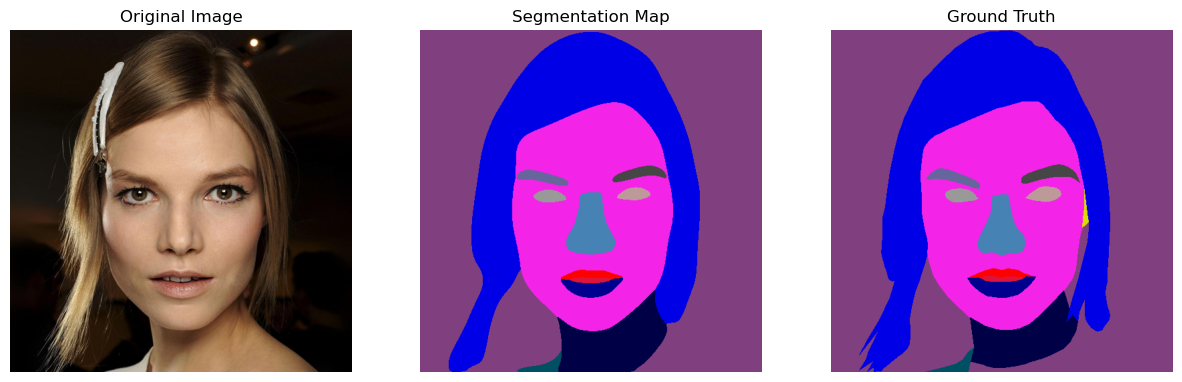

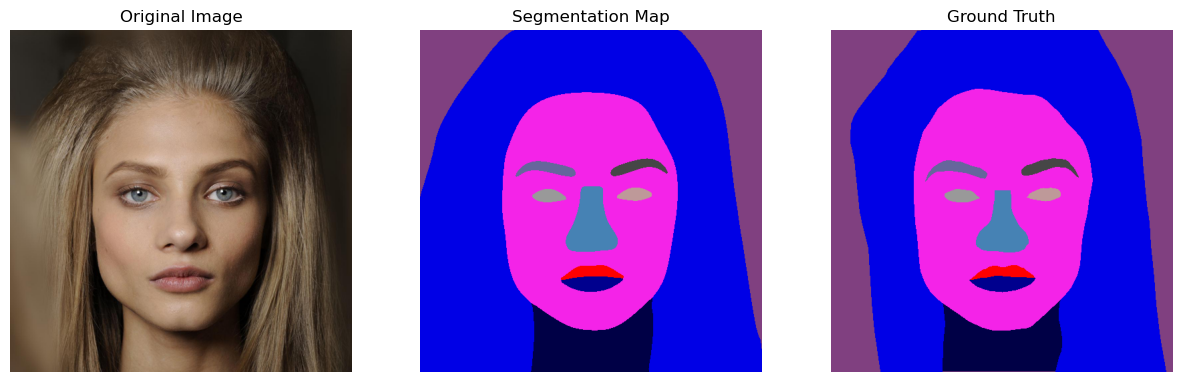

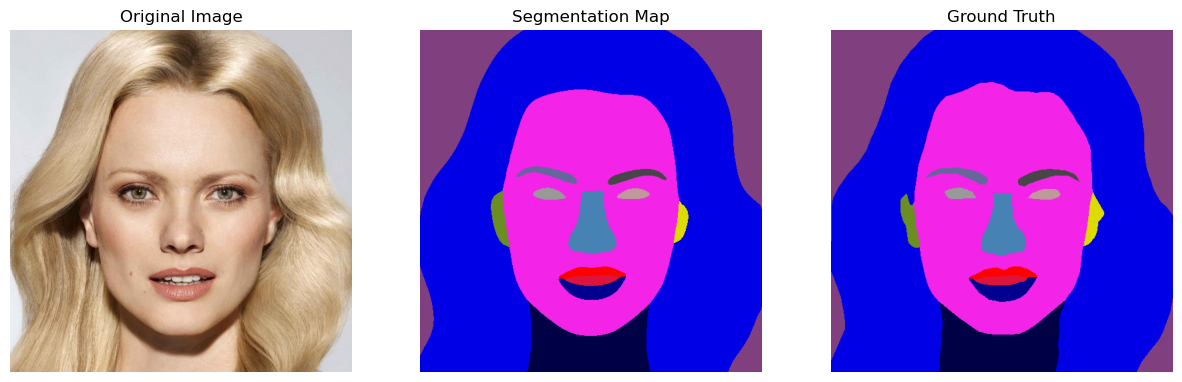

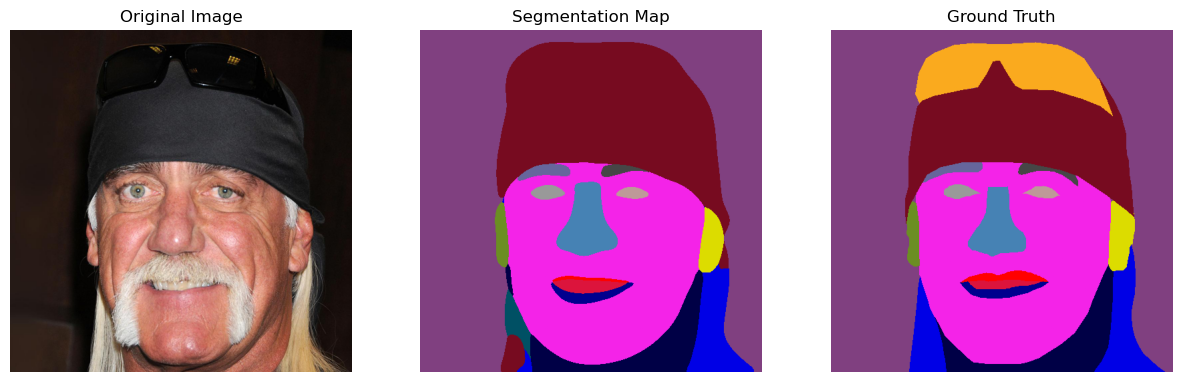

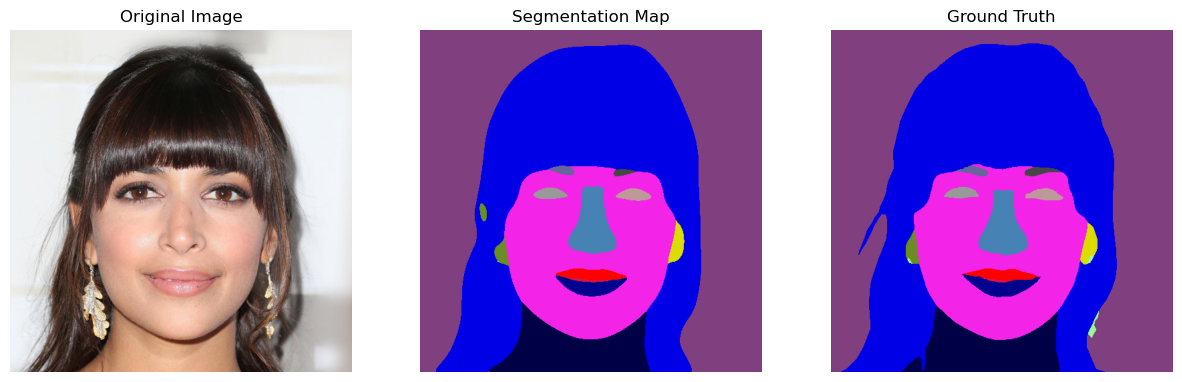

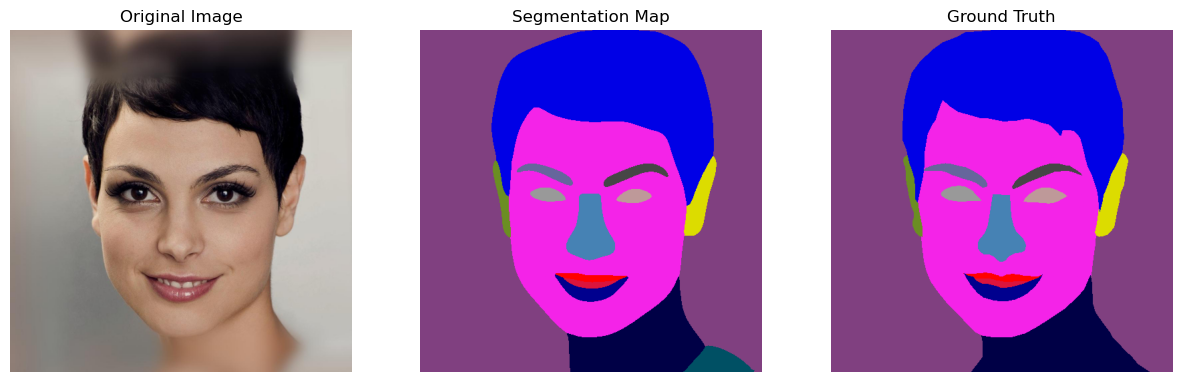

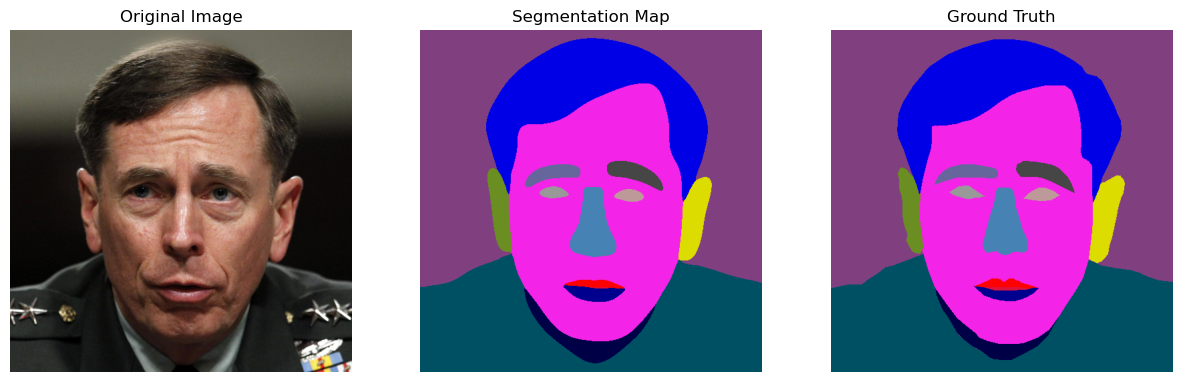

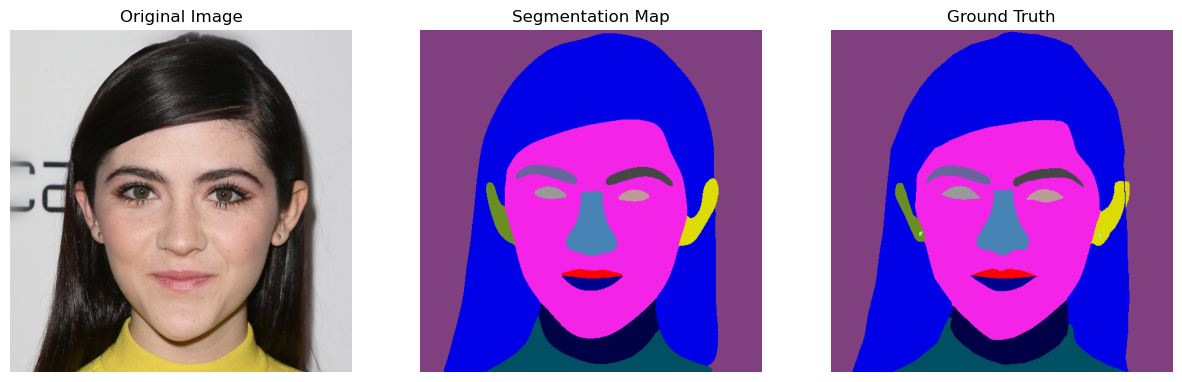

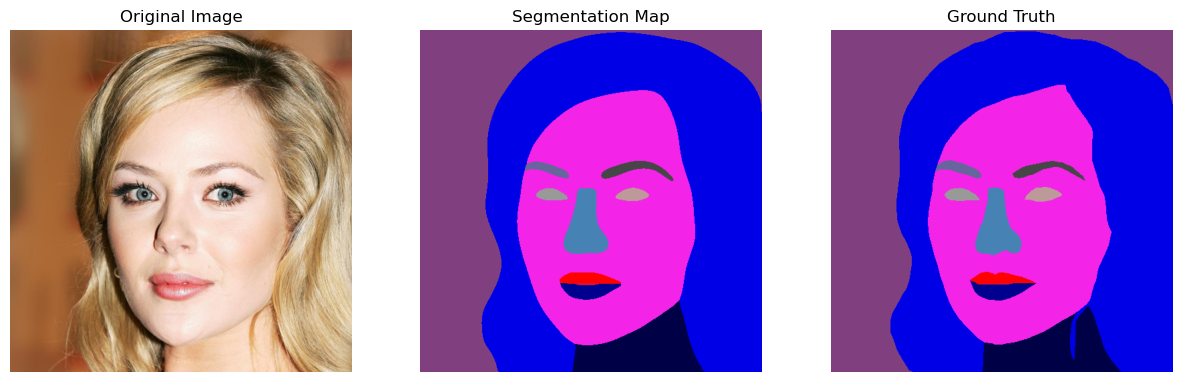

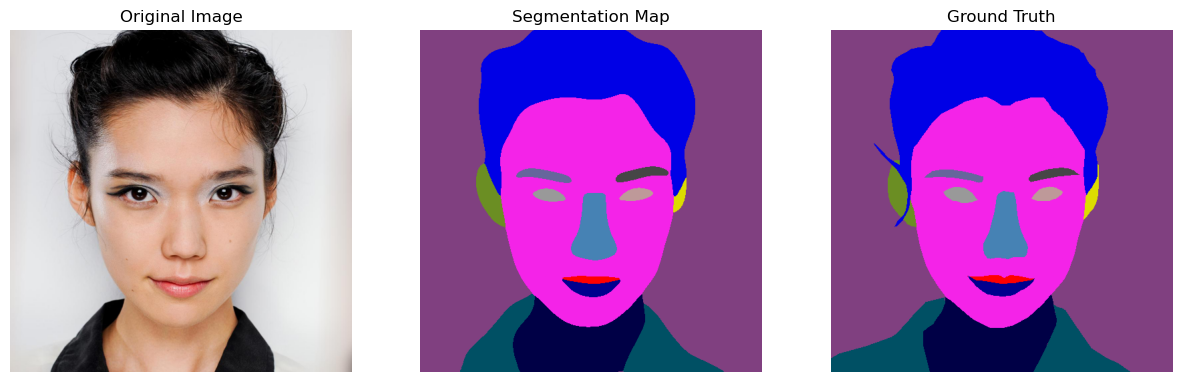

Test Loss: 0.1886


In [9]:

# Training loop
if MODE == 'train':
    train(model, train_loader, test_loader, criterion, optimizer)
elif MODE == 'test':
    test(model, test_loader)
elif MODE == 'csv':
    export_model_to_csv(model, test_loader, save_images=SAVE_IMAGES)